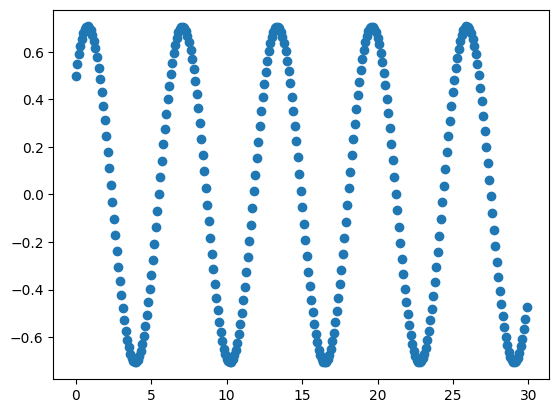

Number of parameters in the model:  1119


100%|██████████| 200/200 [10:38<00:00,  3.19s/it]


In [21]:
from qiskit import QuantumCircuit, execute, Aer
import numpy as np
import torch
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit.library import (
    ZFeatureMap,
    ZZFeatureMap,
    RealAmplitudes,
    EfficientSU2,
)
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from matplotlib import pyplot as plt
from tqdm import tqdm
from math import sin, cos

num_qubits = 2

def create_qnn(num_qubits):
    feature_map = ZFeatureMap(num_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits, reps=1)

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )

    return qnn


def defined_function(x):
    # Given a value x, return sin(x)
    return sin(x) + cos(x) 

size = 30
    
class build_qnn(nn.Module):
    def __init__(self, qnn):
        super(build_qnn, self).__init__()
        self.fc0 = nn.Linear(1, num_qubits)
        self.qnn = TorchConnector(qnn)
        self.fc = nn.Linear(pow(2, num_qubits), size)
        self.fc1 = nn.Linear(size, size)
        self.fc2 = nn.Linear(size, 1)
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.qnn(x)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

def training_step(x_train, y_train, model, criterion, optimizer):
    # Forward pass
    x_train = x_train.to(device='cuda')
    outputs = model(x_train)
    outputs = outputs.to(device='cuda')
    y_train = y_train.to(device='cuda')
    outputs = outputs.float()
    y_train = y_train.float()
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Input values for the defined function
x_train = np.arange(0, 30, 0.1, dtype=np.float32)
x_train = np.array(x_train)
y_train = np.zeros(len(x_train))

x_test = np.arange(0, 30, 0.1, dtype=np.float32)
x_test = np.array(x_test)
y_test = np.zeros(len(x_test))

for i in range(len(x_train)):
    y_train[i] = defined_function(x_train[i])
    y_train[i] = y_train[i] / 2
    
for i in range(len(x_test)):
    y_test[i] = defined_function(x_test[i])
    y_test[i] = y_test[i] / 2

plt.scatter(x_train, y_train)
plt.show()
x_train = torch.from_numpy(x_train.reshape(-1, 1))
y_train = torch.from_numpy(y_train.reshape(-1, 1))

qnn = create_qnn(num_qubits)
model = build_qnn(qnn)
model = model.cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("Number of parameters in the model: ", sum(p.numel() for p in model.parameters()))

# Training loop
for epoch in tqdm(range(200)):
    loss = training_step(x_train, y_train, model, criterion, optimizer)

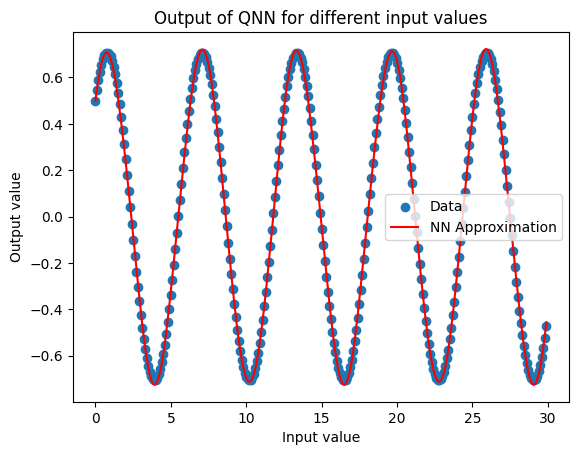

Error:  0.009001301236135741


In [22]:
x_test = torch.from_numpy(x_test.reshape(-1, 1))
x_test = x_test.cuda()
y_test = model(x_test).detach().cpu().numpy()

x_test = x_test.cpu()
    
# Plot the results with the ideal linear function
plt.scatter(x_train.numpy(), y_train.numpy(), label="Data")
plt.plot(x_test, y_test, color="red", label="NN Approximation")
plt.legend()
plt.title("Output of QNN for different input values")
plt.xlabel("Input value")
plt.ylabel("Output value")
plt.show()

print("Error: ", np.mean(np.abs(y_test - y_train.numpy())))